In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install imblearn
from imblearn.over_sampling import SMOTE
from random import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

<h1>Data Loading</h1>

In [ ]:
data = pd.read_csv("/content/train.csv")
data

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,CST_130421,Doris,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
45524,CST_136670,Luciana,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
45525,CST_145435,Jessica,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
45526,CST_130913,Tessa,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


<h1>Data Engineering</h1>

In [ ]:
data.isna().sum()

,0
customer_id,0
name,0
age,0
gender,0
owns_car,547
owns_house,0
no_of_children,774
net_yearly_income,0
no_of_days_employed,463
occupation_type,0


<p>Check the dataset distribution and replace with mean or median</p>

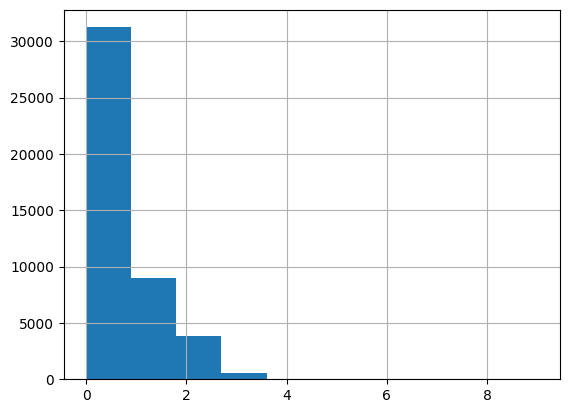

In [ ]:
data.no_of_children.hist()
data.no_of_children.fillna(np.median(data.no_of_children.dropna()), inplace=True)

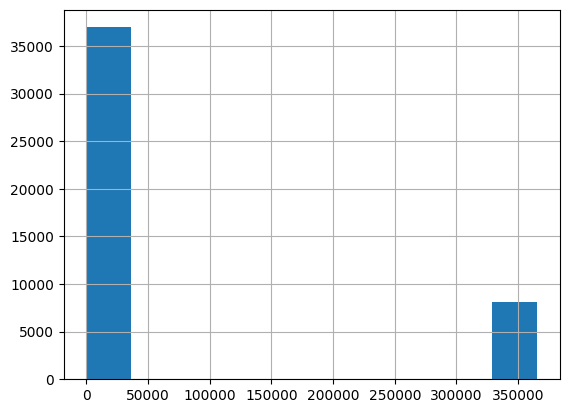

In [ ]:
data.no_of_days_employed.hist()
data.no_of_days_employed.fillna(np.median(data.no_of_days_employed.dropna()), inplace=True)

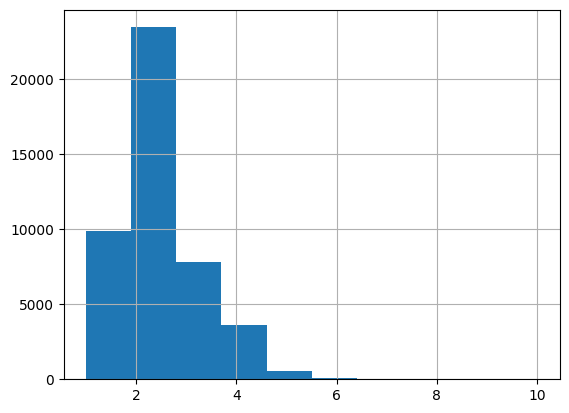

In [ ]:
data.total_family_members.hist()
data.total_family_members.fillna(np.median(data.total_family_members.dropna()), inplace=True)

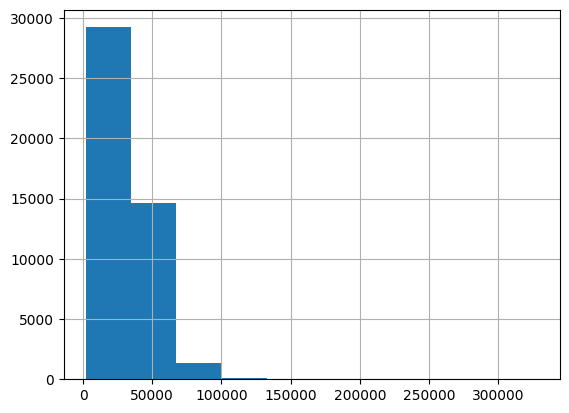

In [ ]:
data.yearly_debt_payments.hist()
data.yearly_debt_payments.fillna(np.median(data.yearly_debt_payments.dropna()), inplace=True)

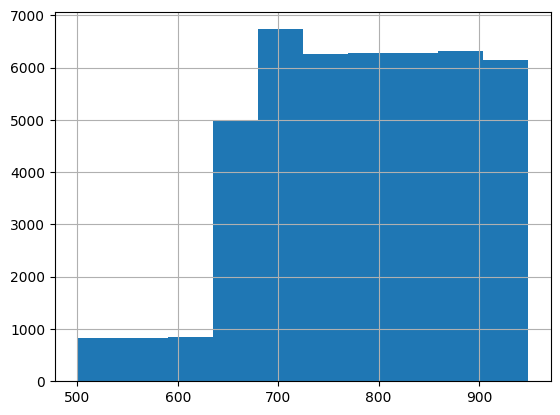

In [ ]:
data.credit_score.hist()
data.credit_score.fillna(np.median(data.credit_score.dropna()), inplace=True)

In [ ]:
data.isna().sum()

,0
customer_id,0
name,0
age,0
gender,0
owns_car,547
owns_house,0
no_of_children,0
net_yearly_income,0
no_of_days_employed,0
occupation_type,0


In [ ]:
data.owns_car.fillna(data.owns_car.mode().values[0],inplace=True)
data.migrant_worker.fillna(data.migrant_worker.mode().values[0],inplace=True)

<h2>Synthetic features</h2>
<p>Generating meaningful synthetic features from the data</p>

In [ ]:
def get_profit_category(value):
    if value < 0 :
        return "Loss"
    elif value == 0 :
        return "Zero"
    else:
        return "Profit"

data["in_hand_balance"] = (data.net_yearly_income - data.yearly_debt_payments)
data["in_profit"] = [get_profit_category(i) for i in data["in_hand_balance"].values]
data["total_income_received"] = data.net_yearly_income * data.no_of_days_employed
data["employment_years"] = (data.no_of_days_employed / 365.0)

In [ ]:
data.employment_years.clip(upper = np.median(data.employment_years), inplace=True)

<h1>Exploratory Data Analysis</h1>

In [ ]:
cnames = {
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
#'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
#'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
#'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
#'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
#'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
#'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
#'slategray':            '#708090',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

colors = list(cnames.keys())

In [ ]:
data.columns

Index(['customer_id', 'name', 'age', 'gender', 'owns_car', 'owns_house',
       'no_of_children', 'net_yearly_income', 'no_of_days_employed',
       'occupation_type', 'total_family_members', 'migrant_worker',
       'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)',
       'credit_score', 'prev_defaults', 'default_in_last_6months',
       'credit_card_default', 'in_hand_balance', 'in_profit',
       'total_income_received', 'employment_years'],
      dtype='object')

<h1>How old are they?</h1>

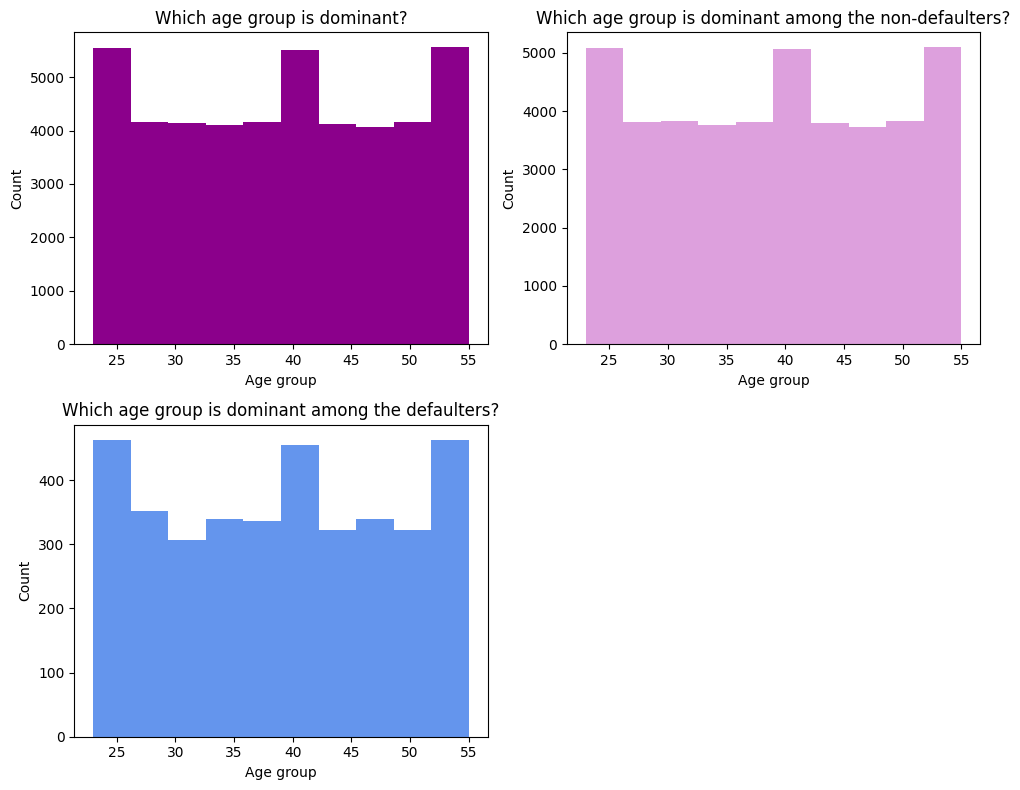

In [ ]:
plt.figure(figsize=(10,8))
shuffle(colors)
plt.subplot(2,2,1)
plt.hist(data.age,color=colors[0])
plt.xlabel("Age group")
plt.ylabel("Count")
plt.title("Which age group is dominant?")

shuffle(colors)
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 0].age,color=colors[0])
plt.xlabel("Age group")
plt.ylabel("Count")
plt.title("Which age group is dominant among the non-defaulters?")

shuffle(colors)
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 1].age,color=colors[0])
plt.xlabel("Age group")
plt.ylabel("Count")
plt.title("Which age group is dominant among the defaulters?")
plt.tight_layout()

<p><b>Inference : </b>Among both classes, <b>25</b> <b>40</b> and <b>55</b> tend to be the dominant ages.</p>

<h1>Which gender is dominant?</h1>

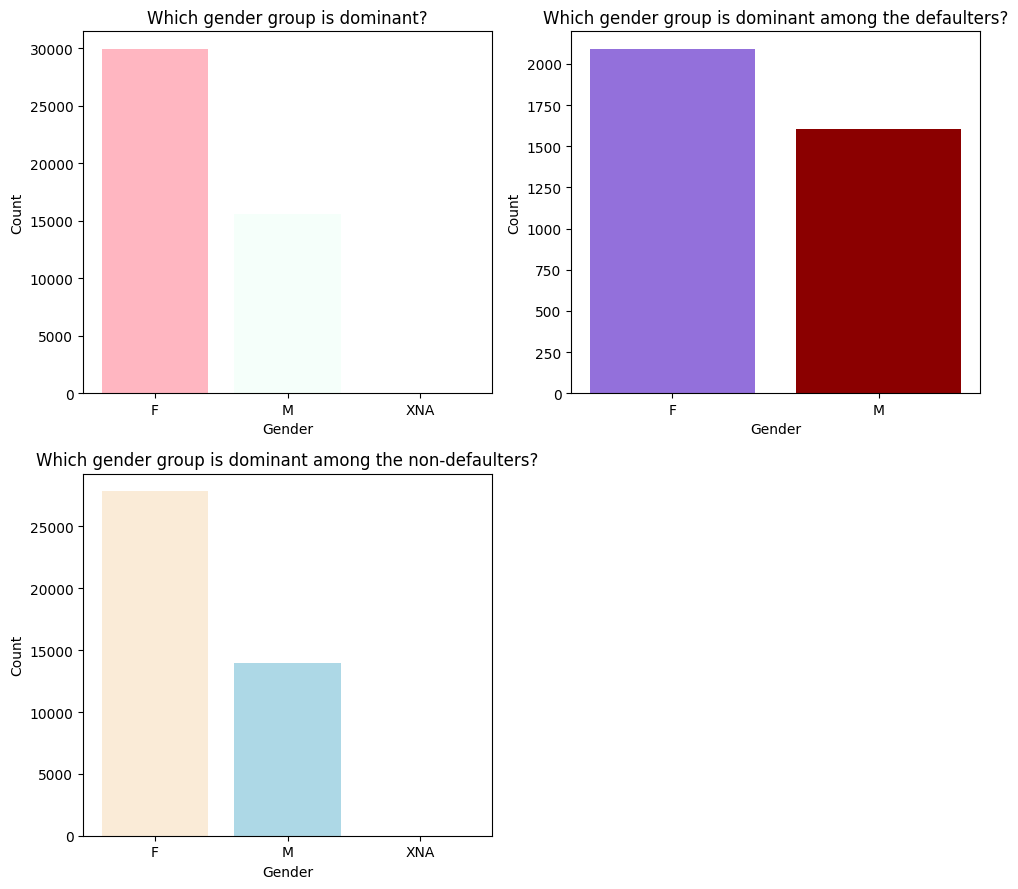

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
shuffle(colors)
un, count = np.unique(data.gender, return_counts=True)
plt.bar(un, count, color=colors)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Which gender group is dominant?")

plt.subplot(2,2,2)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 1].gender, return_counts=True)
plt.bar(un, count, color=colors)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Which gender group is dominant among the defaulters?")

plt.subplot(2,2,3)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 0].gender, return_counts=True)
plt.bar(un, count, color=colors)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Which gender group is dominant among the non-defaulters?")
plt.tight_layout()

<p><b>Inference : </b><b>Females</b> tend to be more <b>Non-defaulters</b> while <b>Males</b> tend to be more in number in <b>Defaulters</b>.</p>

<h1>How many owns a vehicle?</h1>

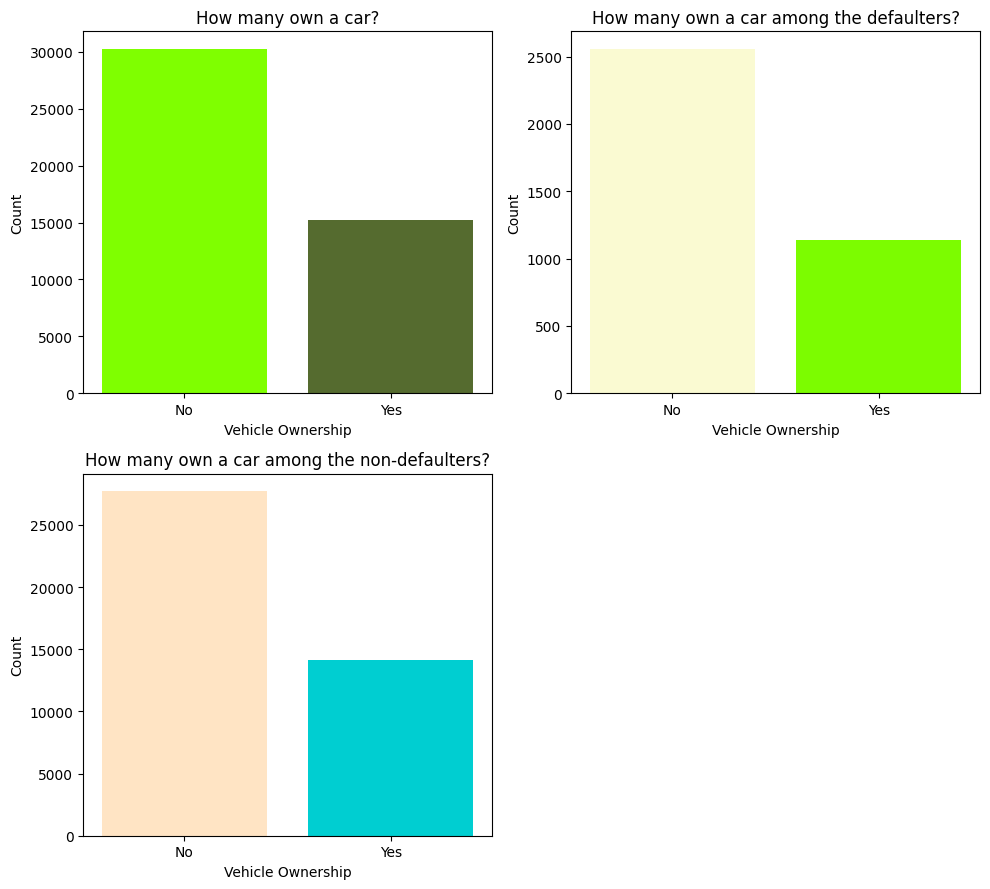

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
shuffle(colors)
un, count = np.unique(data.owns_car.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Vehicle Ownership")
plt.ylabel("Count")
plt.title("How many own a car?")

plt.subplot(2,2,2)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 1].owns_car.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Vehicle Ownership")
plt.ylabel("Count")
plt.title("How many own a car among the defaulters?")

plt.subplot(2,2,3)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 0].owns_car.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Vehicle Ownership")
plt.ylabel("Count")
plt.title("How many own a car among the non-defaulters?")
plt.tight_layout()

<p><b>Inference : </b>Among both classes, majority do not <b>own</b> a car.</p>

<h1>How many have a residence ownership?</h1>

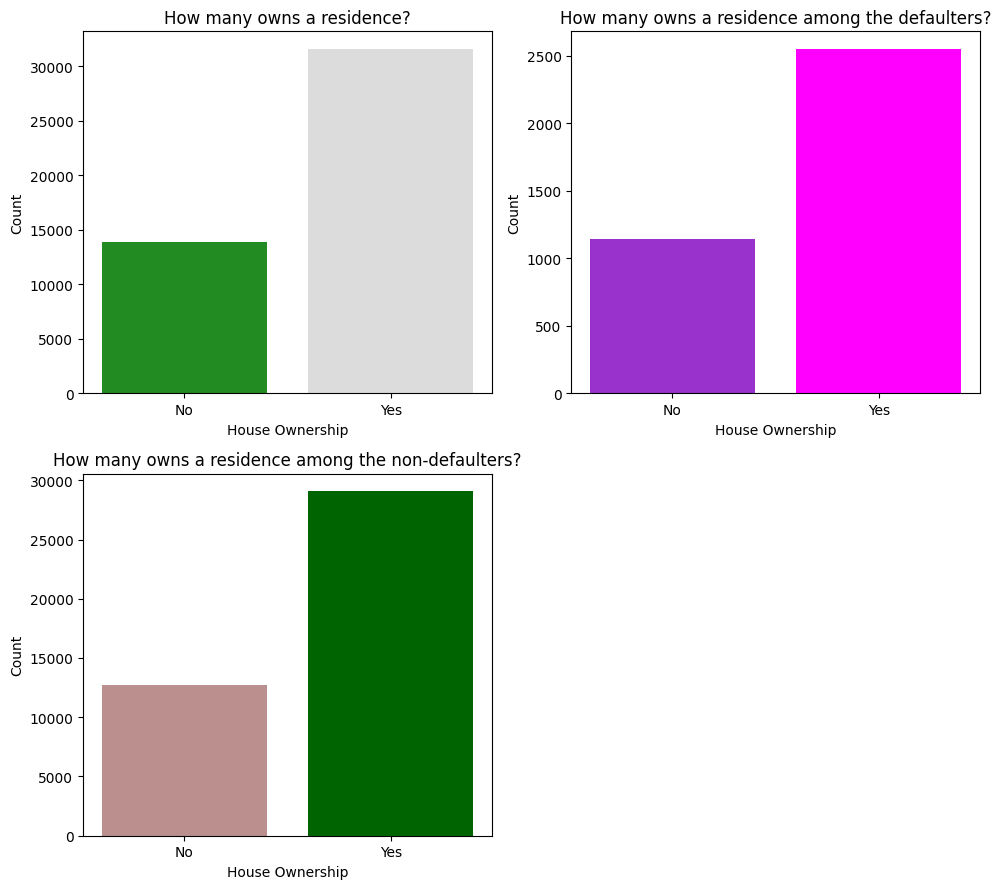

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
shuffle(colors)
un, count = np.unique(data.owns_house.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("House Ownership")
plt.ylabel("Count")
plt.title("How many owns a residence?")

plt.subplot(2,2,2)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 1].owns_house.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("House Ownership")
plt.ylabel("Count")
plt.title("How many owns a residence among the defaulters?")

plt.subplot(2,2,3)
shuffle(colors)
un, count = np.unique(data[data.credit_card_default == 0].owns_house.dropna(), return_counts=True)
un = ["Yes" if i.lower() == "y" else "No" for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("House Ownership")
plt.ylabel("Count")
plt.title("How many owns a residence among the non-defaulters?")
plt.tight_layout()

<p><b>Inference : </b>Majority <b>Own</b> a residence among the defaulters while the opposite happens in the case of <b>Non-defaulters</b>.</p>

<h1>How many children do they have?</h1>

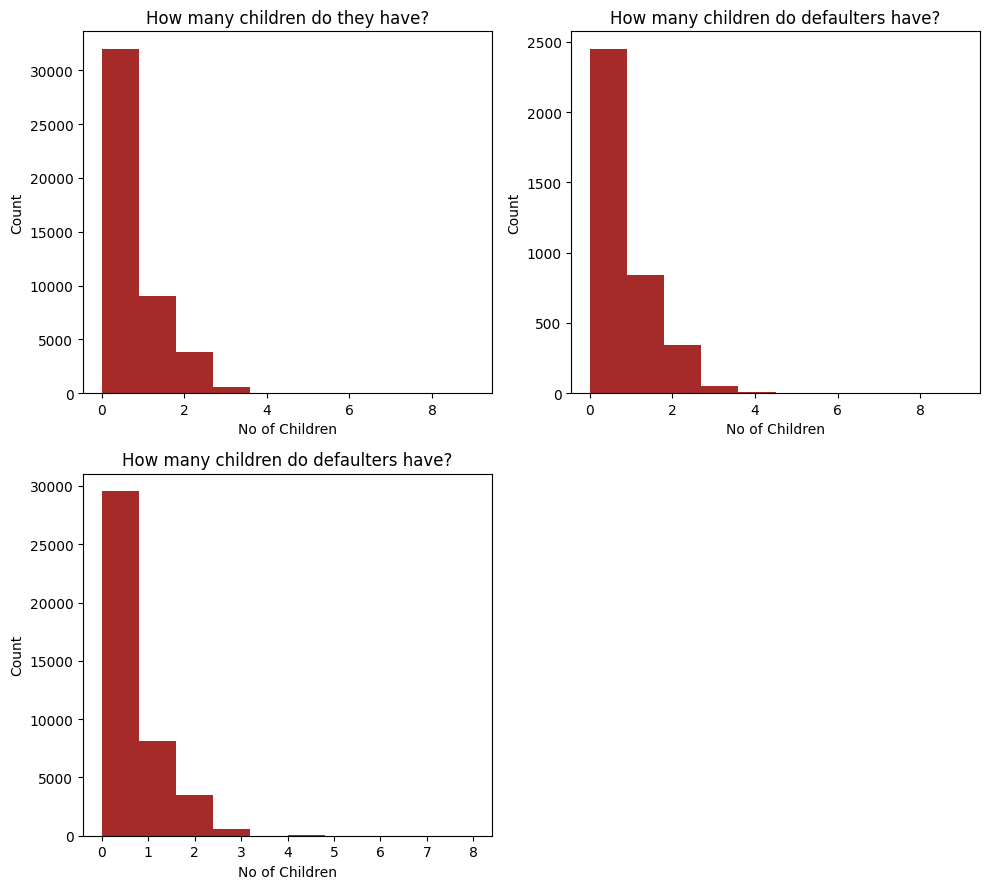

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data.no_of_children,color='brown')
plt.xlabel("No of Children")
plt.ylabel("Count")
plt.title("How many children do they have?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].no_of_children,color='brown')
plt.xlabel("No of Children")
plt.ylabel("Count")
plt.title("How many children do defaulters have?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].no_of_children,color='brown')
plt.xlabel("No of Children")
plt.ylabel("Count")
plt.title("How many children do defaulters have?")
plt.tight_layout()

<p><b>Inference : </b>The distribution stays the <b>same</b> among both classes with negligible variations.</p>

<h1>How much do they earn?</h1>


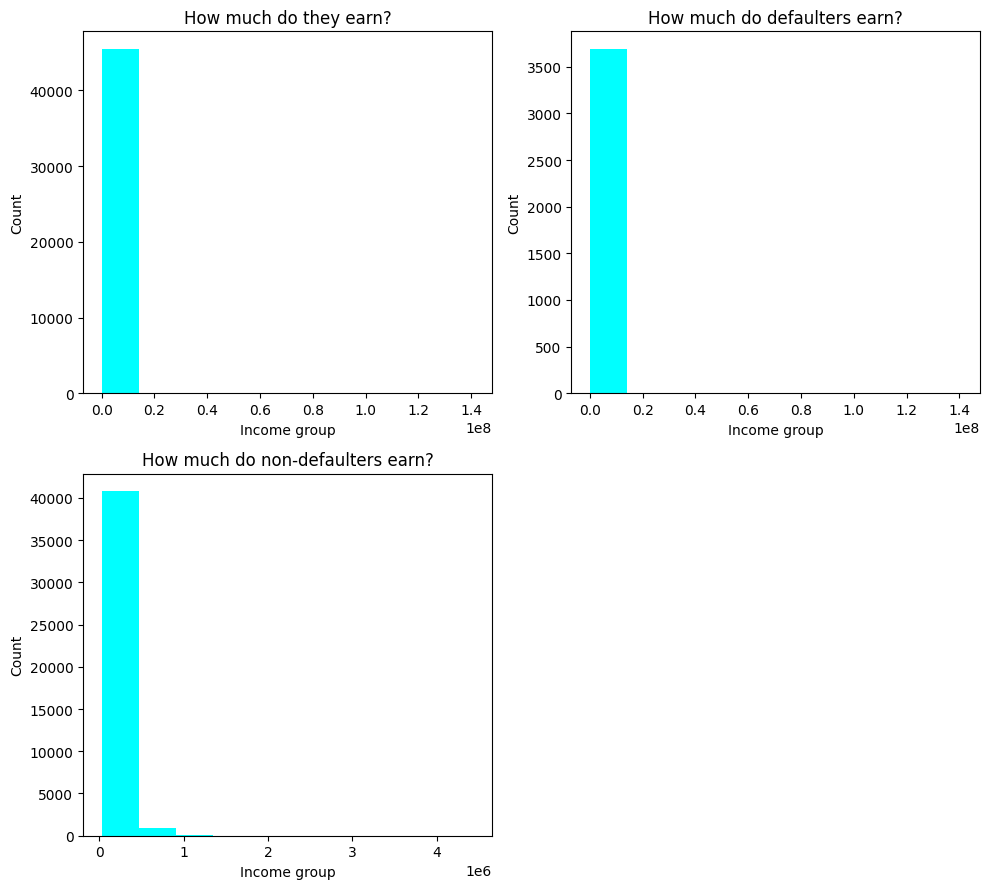

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data.net_yearly_income,color='aqua')
plt.xlabel("Income group")
plt.ylabel("Count")
plt.title("How much do they earn?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].net_yearly_income,color='aqua')
plt.xlabel("Income group")
plt.ylabel("Count")
plt.title("How much do defaulters earn?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].net_yearly_income,color='aqua')
plt.xlabel("Income group")
plt.ylabel("Count")
plt.title("How much do non-defaulters earn?")
plt.tight_layout()

<p><b>Inference : </b>Counter Intuitively, <b>Defaulters</b> earn in higher amount in comparison with <b>Non-defaulters</b></p>

<h1>How long is their work experience?</h1>

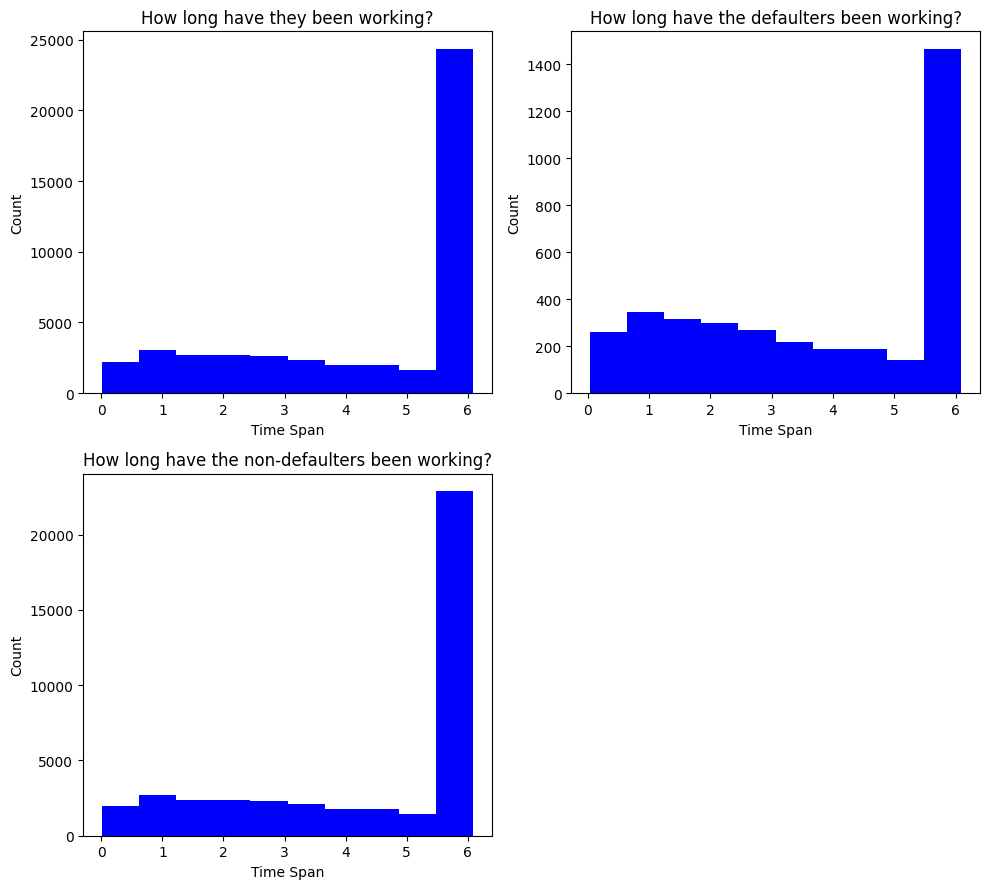

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data.employment_years,color='blue')
plt.xlabel("Time Span")
plt.ylabel("Count")
plt.title("How long have they been working?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].employment_years,color='blue')
plt.xlabel("Time Span")
plt.ylabel("Count")
plt.title("How long have the defaulters been working?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].employment_years,color='blue')
plt.xlabel("Time Span")
plt.ylabel("Count")
plt.title("How long have the non-defaulters been working?")
plt.tight_layout()

<p><b>Inference : </b>Somewhat similar distribution with <b>Moderate Work Experience</b> higher among defaulters.</p>

<h1>What is their work?</h1>

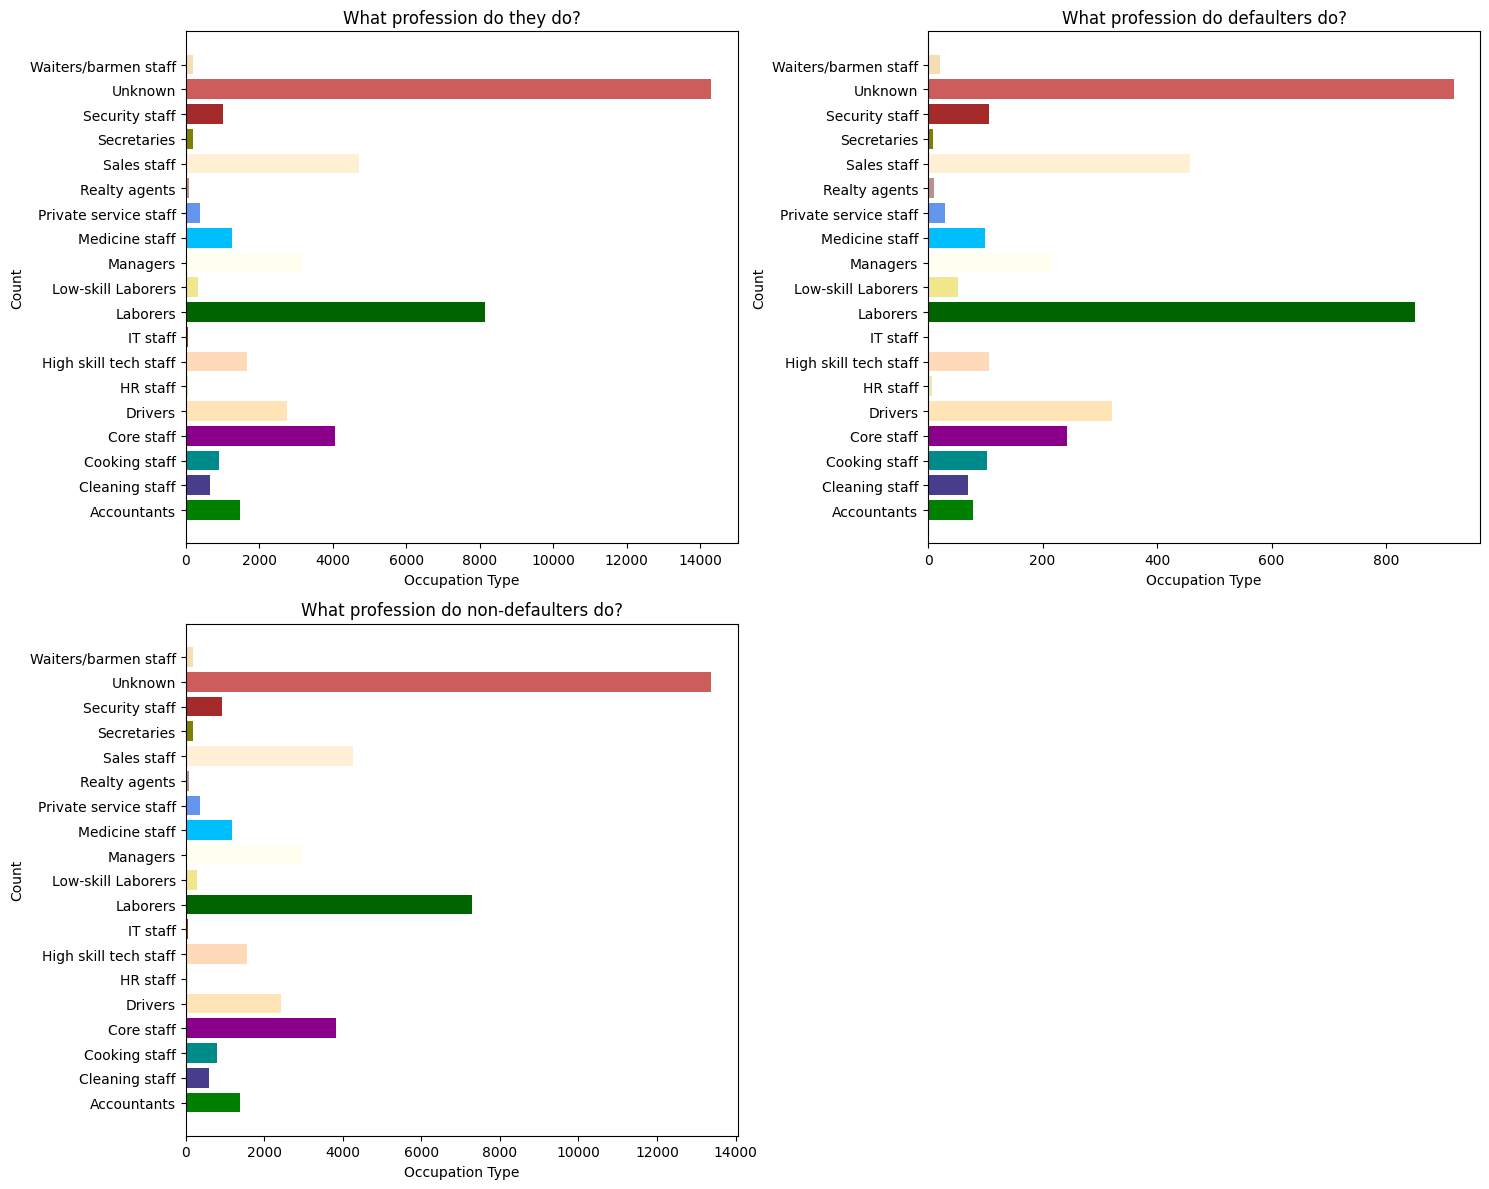

In [ ]:
shuffle(colors)
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
un, count = np.unique(data.occupation_type.dropna(), return_counts=True)
plt.barh(un, count, color=colors)
plt.xlabel("Occupation Type")
plt.ylabel("Count")
plt.title("What profession do they do?")

plt.subplot(2,2,2)
un, count = np.unique(data[data.credit_card_default == 1].occupation_type.dropna(), return_counts=True)
plt.barh(un, count, color=colors)
plt.xlabel("Occupation Type")
plt.ylabel("Count")
plt.title("What profession do defaulters do?")

plt.subplot(2,2,3)
un, count = np.unique(data[data.credit_card_default == 0].occupation_type.dropna(), return_counts=True)
plt.barh(un, count, color=colors)
plt.xlabel("Occupation Type")
plt.ylabel("Count")
plt.title("What profession do non-defaulters do?")
plt.tight_layout()

<p><b>Inference : </b>Comparatively, <b>Defaulters</b> have <b>Low-income</b> jobs compared to <b>Non-Defaulters</b>.</p>

<h1>How big is their family</h1>

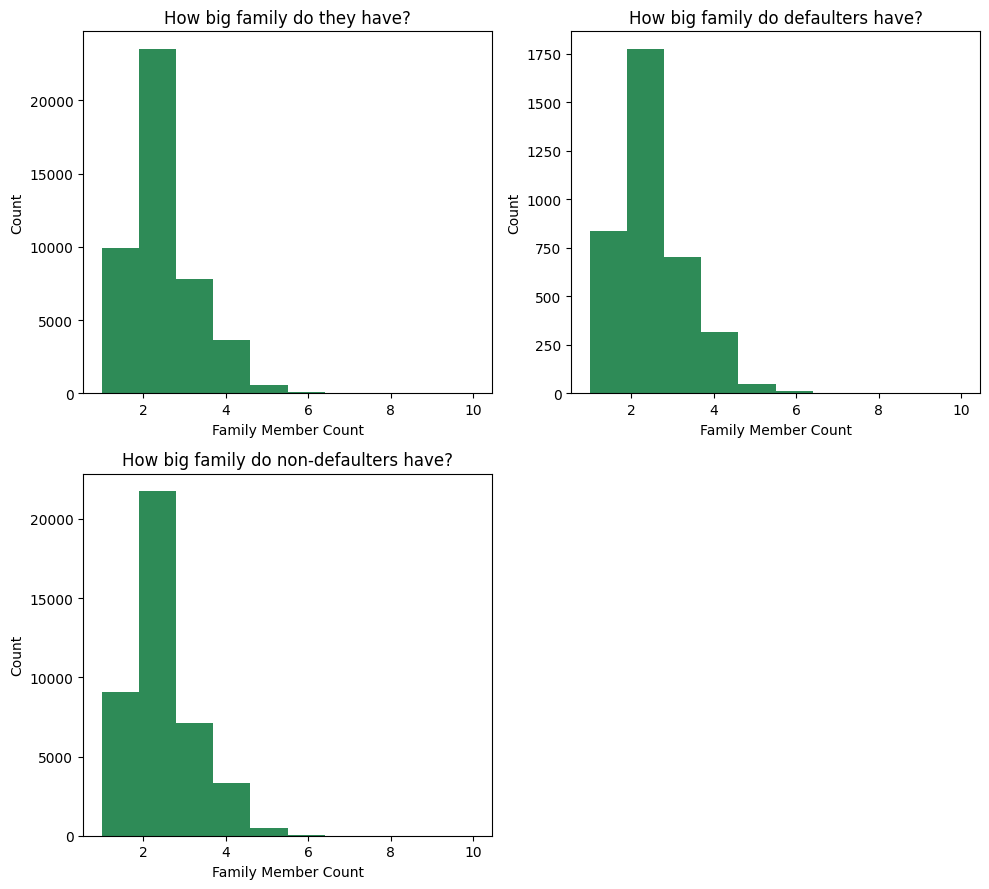

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data.total_family_members,color='seagreen')
plt.xlabel("Family Member Count")
plt.ylabel("Count")
plt.title("How big family do they have?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].total_family_members,color='seagreen')
plt.xlabel("Family Member Count")
plt.ylabel("Count")
plt.title("How big family do defaulters have?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].total_family_members,color='seagreen')
plt.xlabel("Family Member Count")
plt.ylabel("Count")
plt.title("How big family do non-defaulters have?")
plt.tight_layout()

<p><b>Inference : </b>Similar distributions with neglible variations.</p>

<h1>Are they a migrant?</h1>

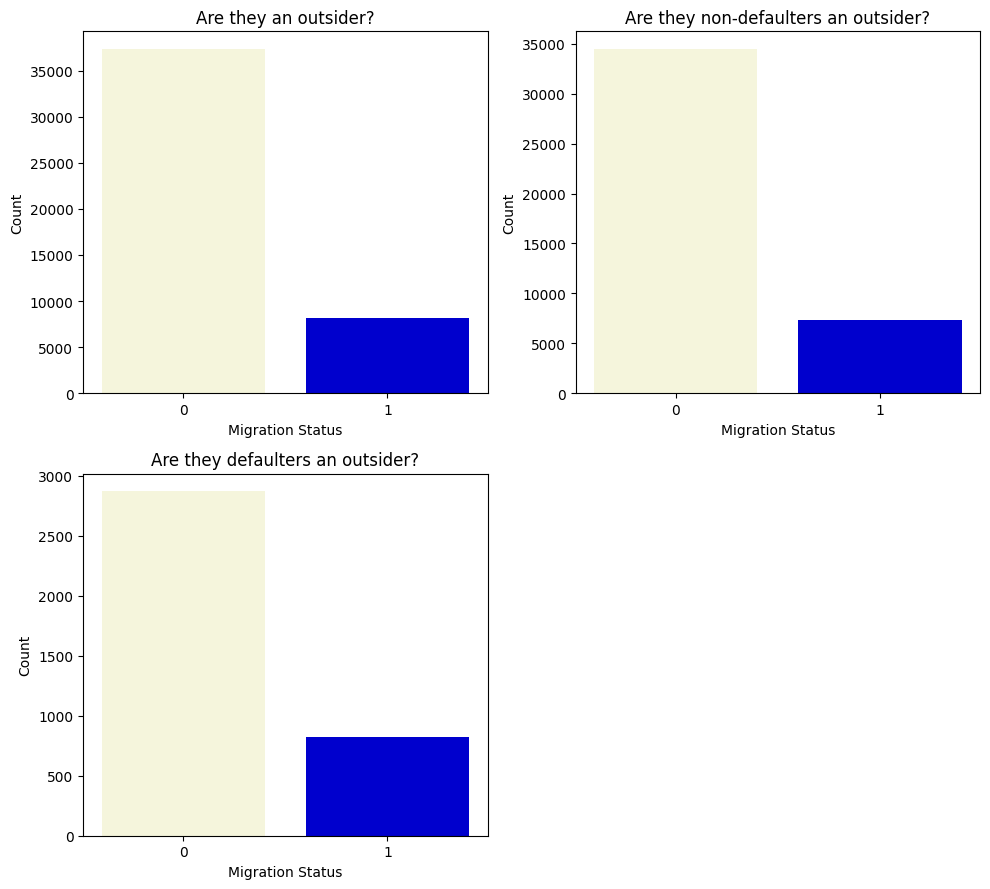

In [ ]:
shuffle(colors)
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
un, count = np.unique(data.migrant_worker.dropna(), return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color = colors)
plt.xlabel("Migration Status")
plt.ylabel("Count")
plt.title("Are they an outsider?")
plt.subplot(2,2,2)
un, count = np.unique(data[data.credit_card_default == 0].migrant_worker.dropna(), return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color = colors)
plt.xlabel("Migration Status")
plt.ylabel("Count")
plt.title("Are they non-defaulters an outsider?")
plt.subplot(2,2,3)
un, count = np.unique(data[data.credit_card_default == 1].migrant_worker.dropna(), return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color = colors)
plt.xlabel("Migration Status")
plt.ylabel("Count")
plt.title("Are they defaulters an outsider?")
plt.tight_layout()

<p><b>Inference : </b>There is a small variation in the migration status for <b>Defaulters</b>, where there are comparatively more <b>Outsiders</b>.</p>

<h1>How much is their debt?</h1>

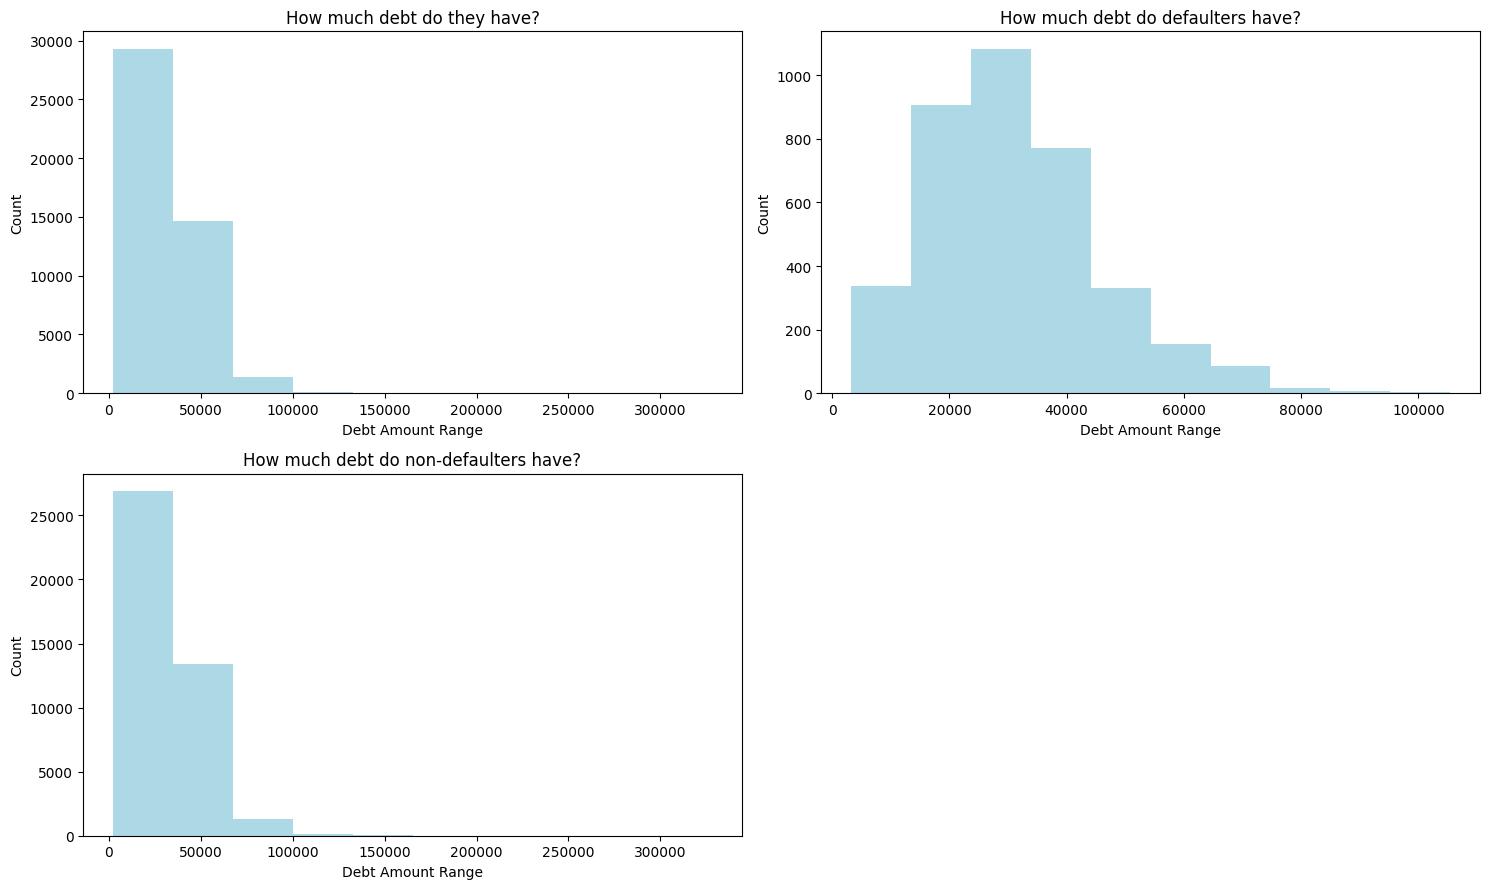

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.hist(data.yearly_debt_payments, color="lightblue")
plt.xlabel("Debt Amount Range")
plt.ylabel("Count")
plt.title("How much debt do they have?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].yearly_debt_payments, color="lightblue")
plt.xlabel("Debt Amount Range")
plt.ylabel("Count")
plt.title("How much debt do defaulters have?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].yearly_debt_payments, color="lightblue")
plt.xlabel("Debt Amount Range")
plt.ylabel("Count")
plt.title("How much debt do non-defaulters have?")
plt.tight_layout()

<p><b>Inference : </b>The debt status of both classes are similar with negligible variation.</p>

<h1>What is their credit limit?</h1>

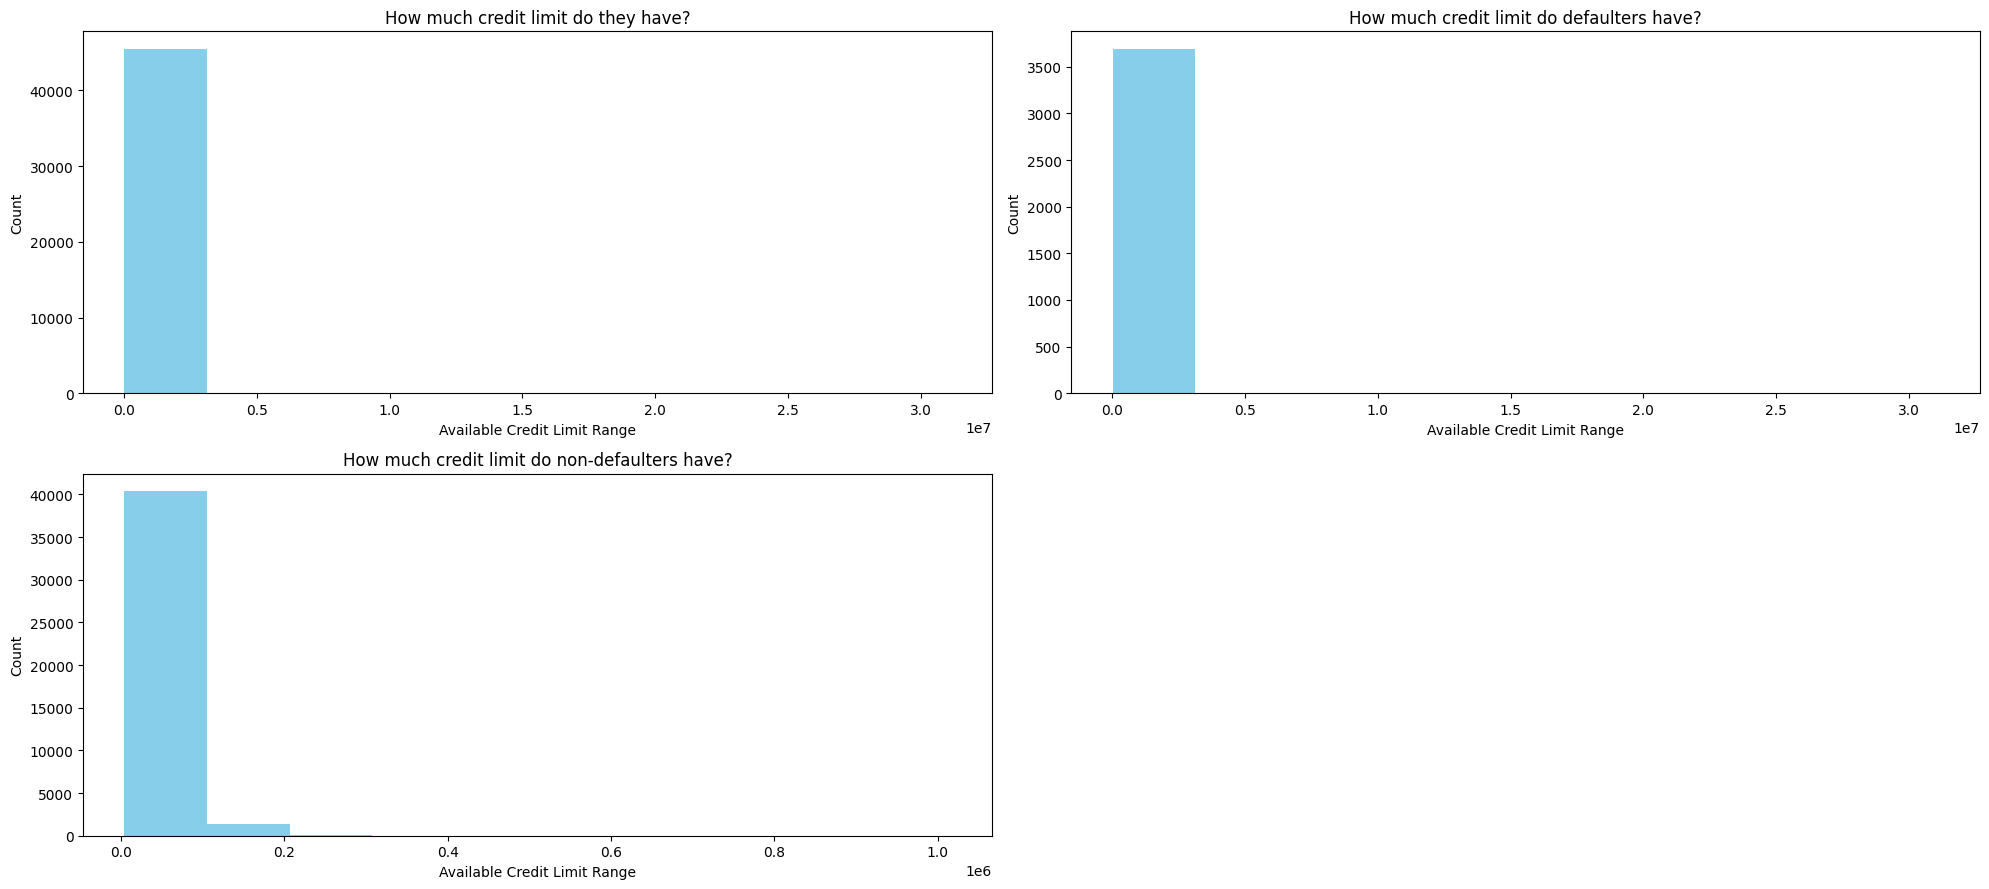

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.ticklabel_format(useOffset=False)
plt.hist(data.credit_limit, color="skyblue")
plt.xlabel("Available Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit do they have?")

plt.subplot(2,2,2)
plt.ticklabel_format(useOffset=False)
plt.hist(data[data.credit_card_default == 1].credit_limit, color="skyblue")
plt.xlabel("Available Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit do defaulters have?")

plt.subplot(2,2,3)
plt.ticklabel_format(useOffset=False)
plt.hist(data[data.credit_card_default == 0].credit_limit, color="skyblue")
plt.xlabel("Available Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit do non-defaulters have?")
plt.tight_layout()

<p><b>Inference : </b><b>Defaulters</b> have a <b>higher</b> credit limit in comparison with <b>Non-Defaulters</b> </p>

<h1>How much credit limit they used?</h1>

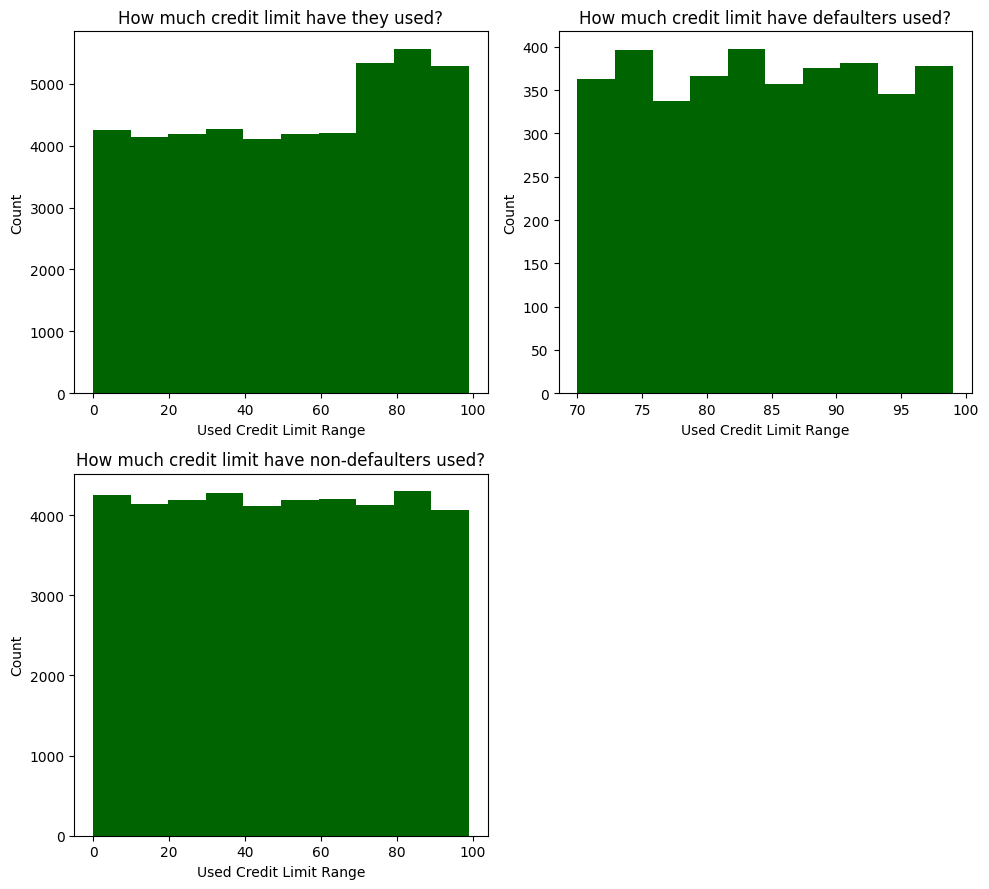

In [ ]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data['credit_limit_used(%)'], color="darkgreen")
plt.xlabel("Used Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit have they used?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1]['credit_limit_used(%)'], color="darkgreen")
plt.xlabel("Used Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit have defaulters used?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0]['credit_limit_used(%)'], color="darkgreen")
plt.xlabel("Used Credit Limit Range")
plt.ylabel("Count")
plt.title("How much credit limit have non-defaulters used?")
plt.tight_layout()

<p><b>Inference : </b><b>Defaulters</b> have used a major part of their credit limit- <b>70%</b> or more in comparison with <b>Non-Defaulters</b> where there is a minimum usage of <b>0%</b>.</p>

<h1>What is their credit score?</h1>

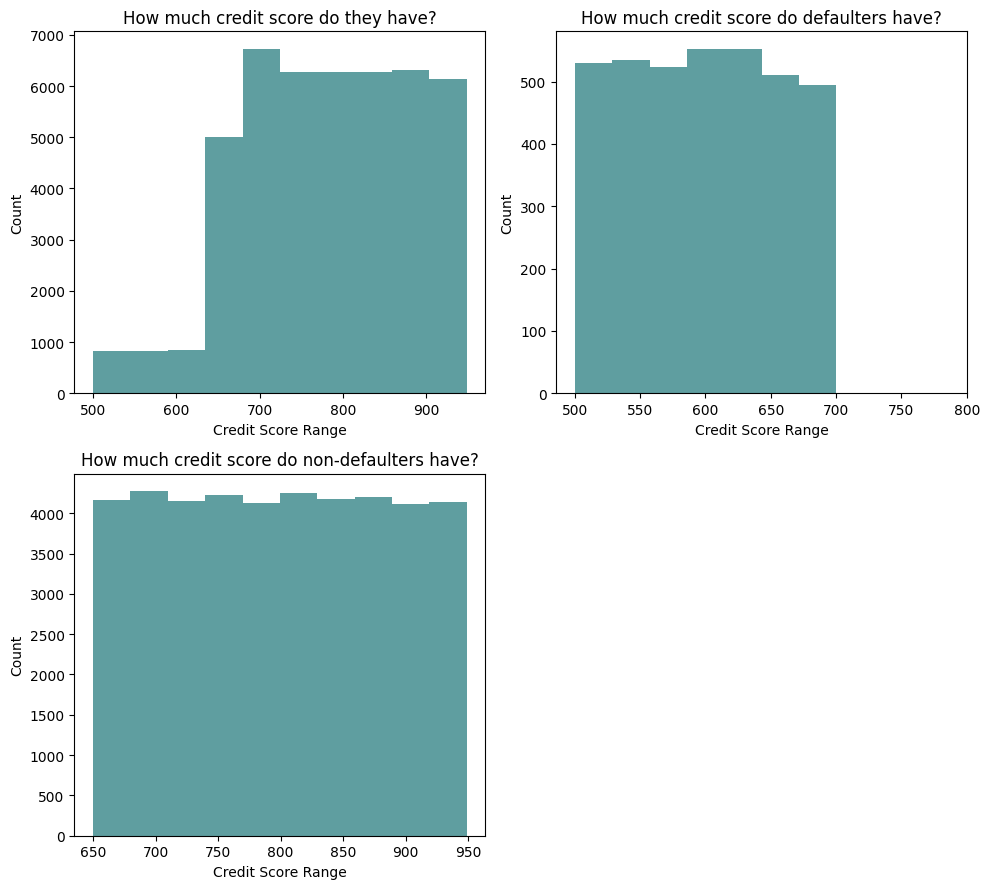

In [ ]:
shuffle(colors)
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.hist(data.credit_score, color=colors[0])
plt.xlabel("Credit Score Range")
plt.ylabel("Count")
plt.title("How much credit score do they have?")
plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].credit_score, color=colors[0])
plt.xlabel("Credit Score Range")
plt.ylabel("Count")
plt.title("How much credit score do defaulters have?")
plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].credit_score, color=colors[0])
plt.xlabel("Credit Score Range")
plt.ylabel("Count")
plt.title("How much credit score do non-defaulters have?")
plt.tight_layout()

<p><b>Inference : </b>The credit score of <b>Defaulters</b> range from <b>500 - 700</b> while for <b>Non-Defaulters</b> range from <b>650 - 950</b>.</p>

<h1>How much time did they default before?</h1>

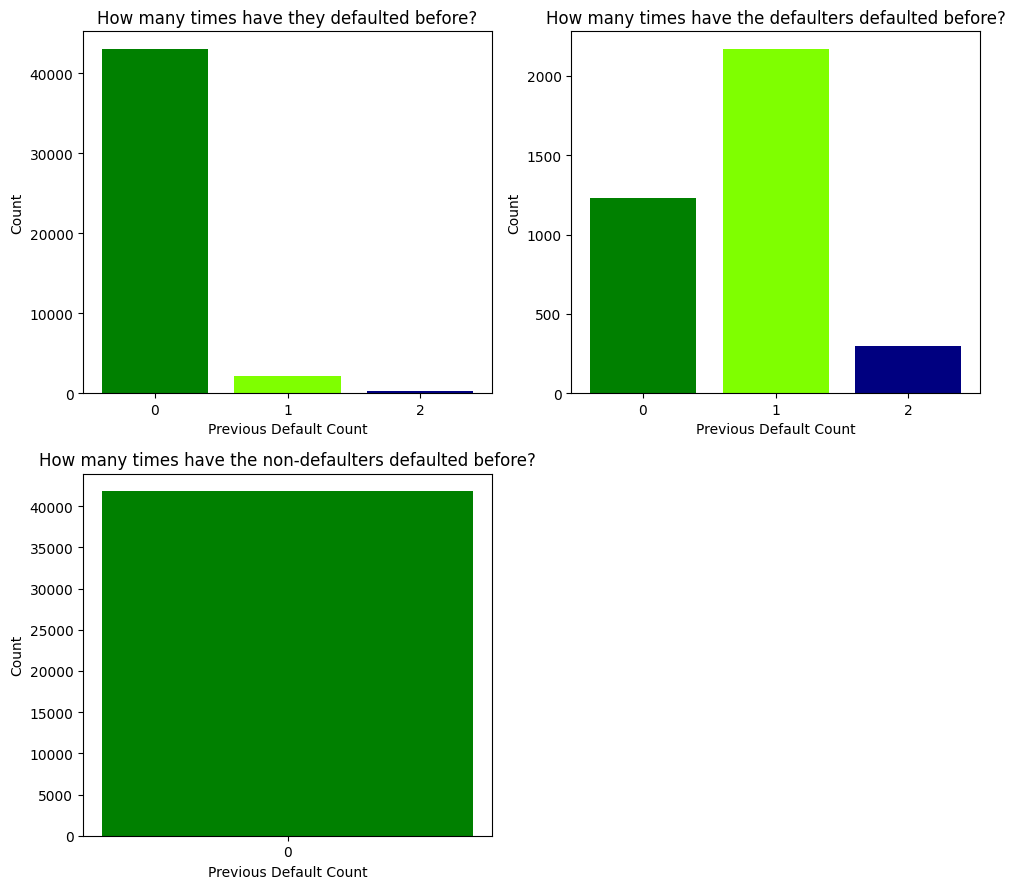

In [ ]:
shuffle(colors)
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
un, count = np.unique(data.prev_defaults, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Previous Default Count")
plt.ylabel("Count")
plt.title("How many times have they defaulted before?")
plt.subplot(2,2,2)
un, count = np.unique(data[data.credit_card_default == 1].prev_defaults, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Previous Default Count")
plt.ylabel("Count")
plt.title("How many times have the defaulters defaulted before?")
plt.subplot(2,2,3)
un, count = np.unique(data[data.credit_card_default == 0].prev_defaults, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Previous Default Count")
plt.ylabel("Count")
plt.title("How many times have the non-defaulters defaulted before?")
plt.tight_layout()

<p><b>Inference : </b>Majority of the <b>Defaulters</b> have defaulted <b>Atleast</b> previously.</p>

<h1>Have they defaulted recently?</h1>

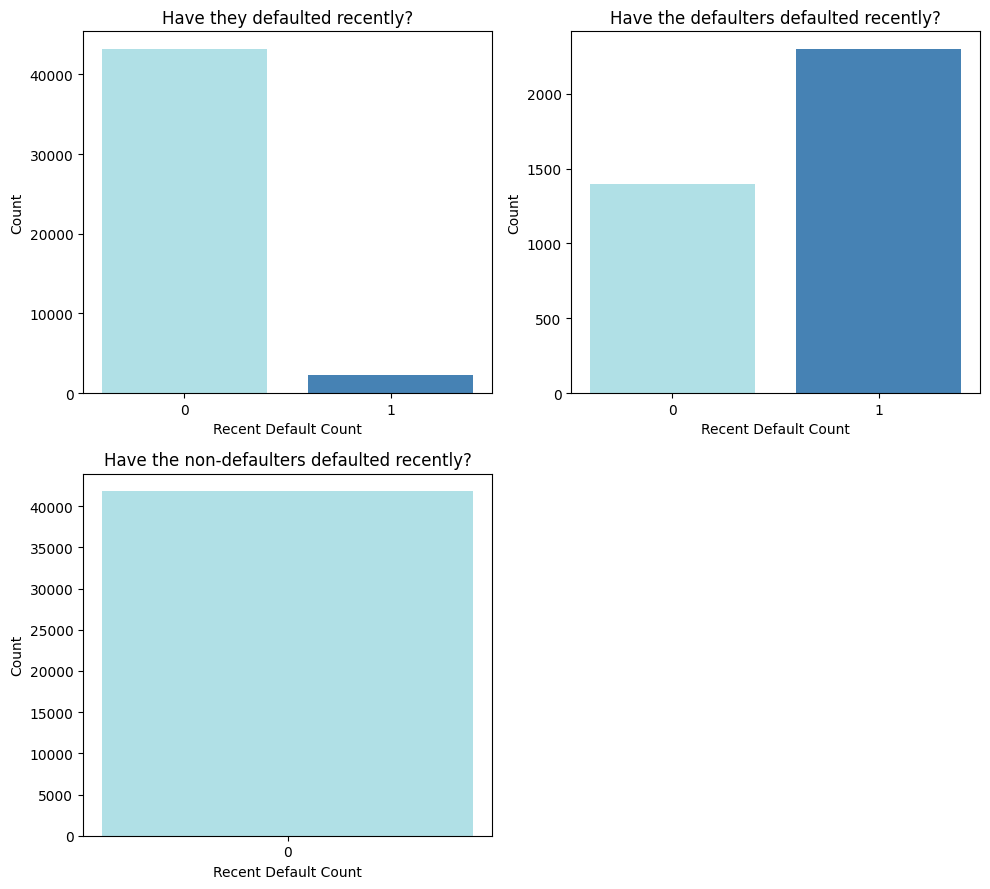

In [ ]:
shuffle(colors)
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
un, count = np.unique(data.default_in_last_6months, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Recent Default Count")
plt.ylabel("Count")
plt.title("Have they defaulted recently?")
plt.subplot(2,2,2)
un, count = np.unique(data[data.credit_card_default == 1].default_in_last_6months, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Recent Default Count")
plt.ylabel("Count")
plt.title("Have the defaulters defaulted recently?")
plt.subplot(2,2,3)
un, count = np.unique(data[data.credit_card_default == 0].default_in_last_6months, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color=colors)
plt.xlabel("Recent Default Count")
plt.ylabel("Count")
plt.title("Have the non-defaulters defaulted recently?")
plt.tight_layout()

<p><b>Inference : </b>Majority of the defaulters have <b>Defaulted</b> in the last 6 months.</p>

<h1>How much Profit / Loss occurs to them?</h1>

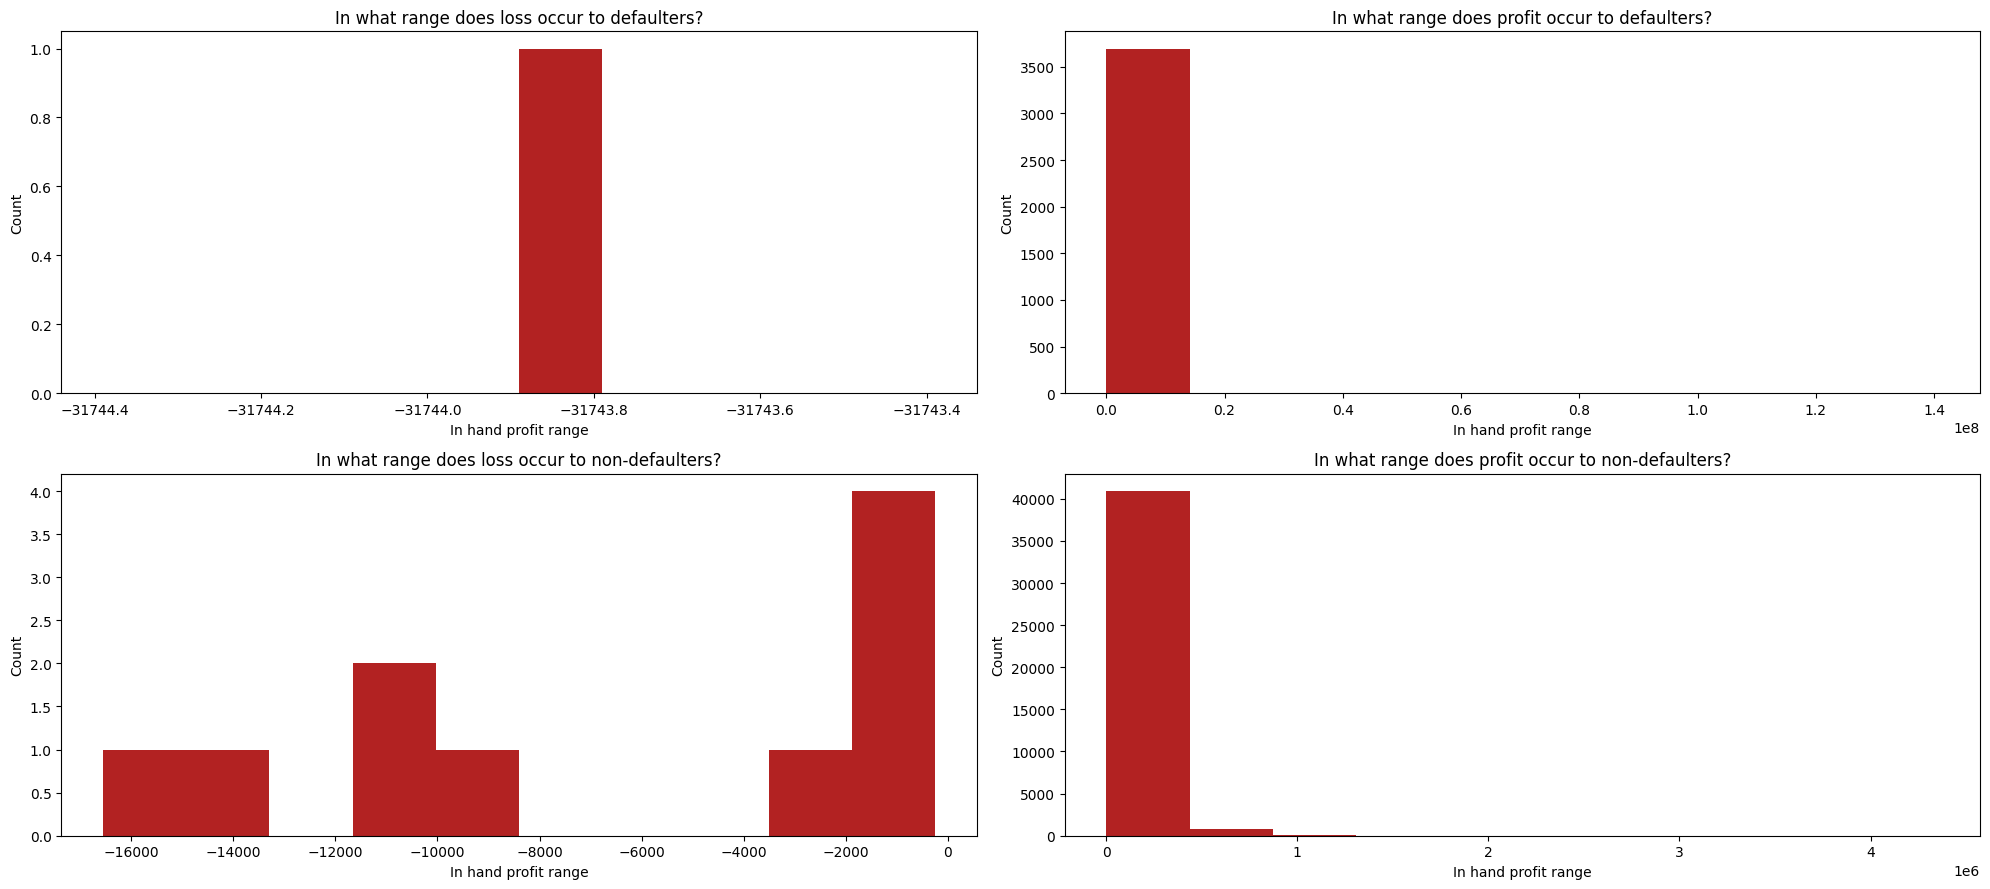

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
shuffle(colors)
plt.xlabel("In hand profit range")
plt.ylabel("Count")
plt.title("In what range does loss occur to defaulters?")
plt.ticklabel_format(useOffset=False)
plt.hist([i for i in data[data.credit_card_default == 1].in_hand_balance if i < 0], color=colors[0])

plt.subplot(2,2,2)
plt.xlabel("In hand profit range")
plt.ylabel("Count")
plt.title("In what range does profit occur to defaulters?")
plt.ticklabel_format(useOffset=False)
plt.hist([i for i in data[data.credit_card_default == 1].in_hand_balance if i >= 0], color=colors[0])

plt.subplot(2,2,3)
plt.xlabel("In hand profit range")
plt.ylabel("Count")
plt.title("In what range does loss occur to non-defaulters?")
plt.ticklabel_format(useOffset=False)
plt.hist([i for i in data[data.credit_card_default == 0].in_hand_balance if i < 0], color=colors[0])

plt.subplot(2,2,4)
plt.xlabel("In hand profit range")
plt.ylabel("Count")
plt.title("In what range does profit occur to non-defaulters?")
plt.ticklabel_format(useOffset=False)
plt.hist([i for i in data[data.credit_card_default == 0].in_hand_balance if i >= 0], color=colors[0])

plt.tight_layout()

<p><b>Inference : </b>For <b>Defaulters</b>, the loss seems to be a higher number in comparison with <b>Non-Defaulters</b>, but counter intuitively, In hand profit appears <b>Higher</b> for <b>Defaulters</b>.</p>

<h1>How many are saving?</h1>

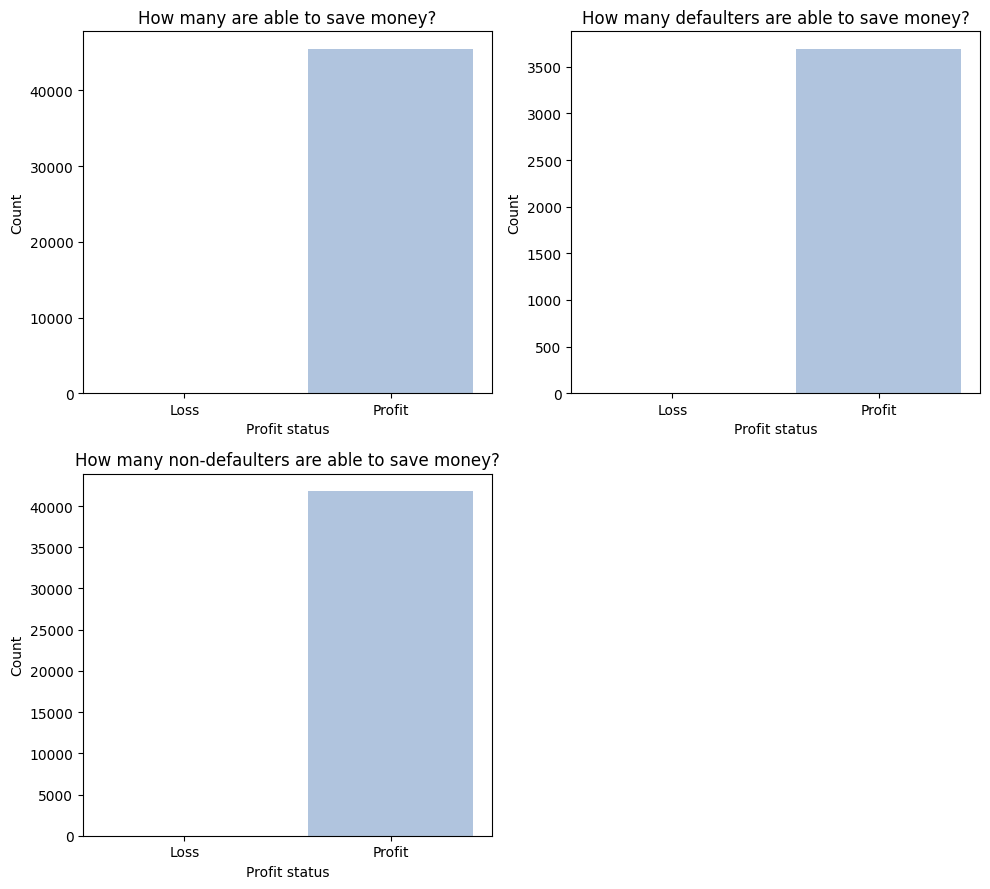

In [ ]:
shuffle(colors)
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
un, count = np.unique(data.in_profit, return_counts=True)
plt.bar(un, count, color=colors)
plt.title("How many are able to save money?")
plt.xlabel("Profit status")
plt.ylabel("Count")
plt.subplot(2,2,2)
un, count = np.unique(data[data.credit_card_default == 1].in_profit, return_counts=True)
plt.bar(un, count, color=colors)
plt.title("How many defaulters are able to save money?")
plt.xlabel("Profit status")
plt.ylabel("Count")
plt.subplot(2,2,3)
un, count = np.unique(data[data.credit_card_default == 0].in_profit, return_counts=True)
plt.bar(un, count, color=colors)
plt.title("How many non-defaulters are able to save money?")
plt.xlabel("Profit status")
plt.ylabel("Count")
plt.tight_layout()

<p><b>Inference : </b> All of them are making a <b>profit</b>, with negligibly less <b>Loss</b> makers.</p>

<h1>How much do they earn?</h1>

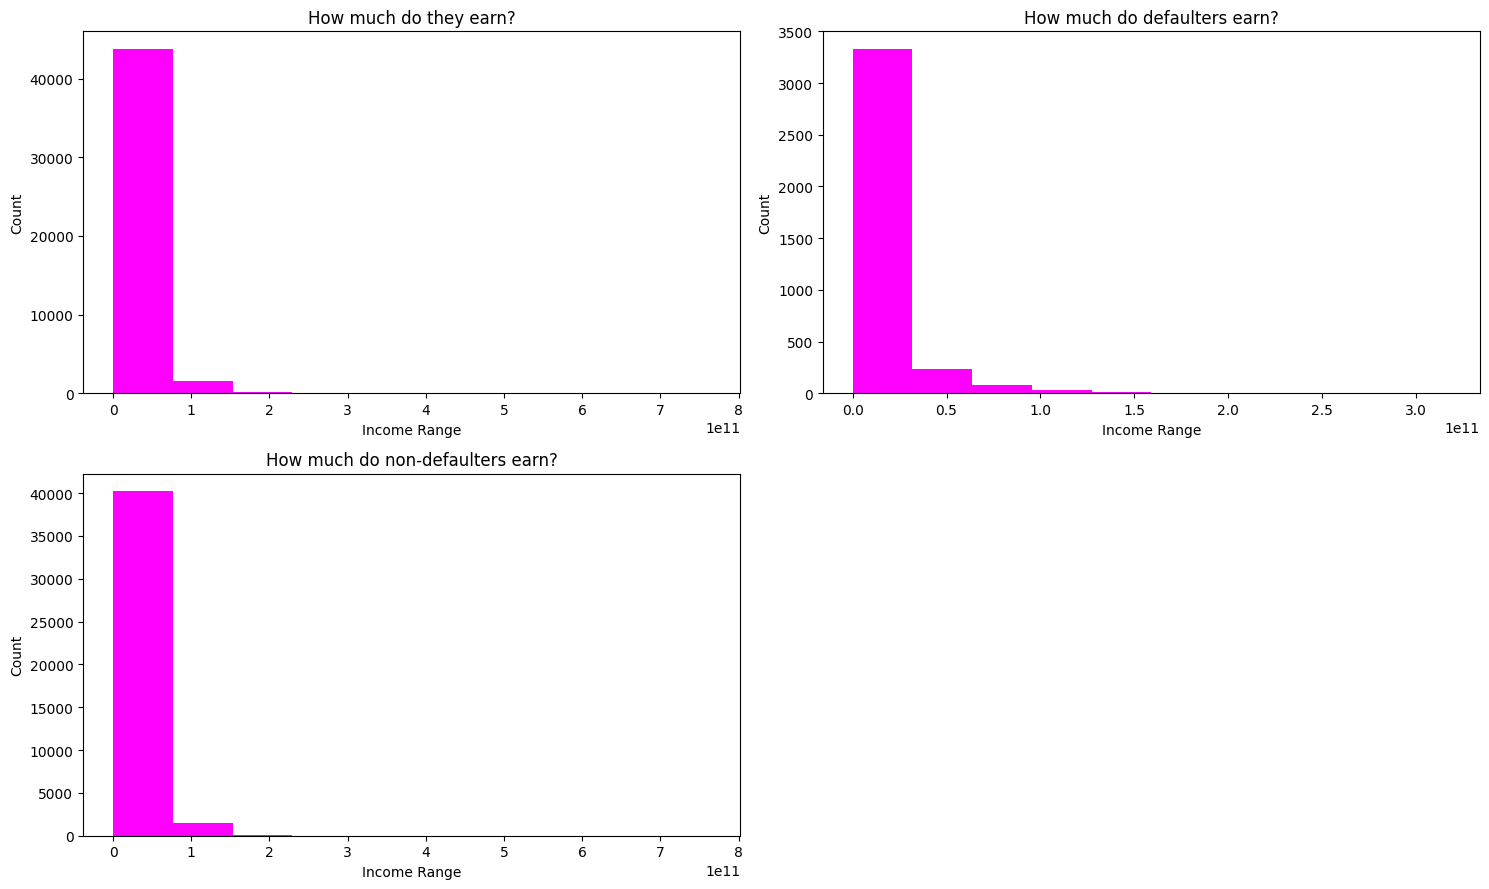

In [ ]:
shuffle(colors)
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.hist(data.total_income_received, color=colors[0])
plt.xlabel("Income Range")
plt.ylabel("Count")
plt.title("How much do they earn?")

plt.subplot(2,2,2)
plt.hist(data[data.credit_card_default == 1].total_income_received, color=colors[0])
plt.xlabel("Income Range")
plt.ylabel("Count")
plt.title("How much do defaulters earn?")

plt.subplot(2,2,3)
plt.hist(data[data.credit_card_default == 0].total_income_received, color=colors[0])
plt.xlabel("Income Range")
plt.ylabel("Count")
plt.title("How much do non-defaulters earn?")
plt.tight_layout()

<p><b>Inference : </b><b>Defaulters</b> are having a slightly higher income range in comparison with <b>Non-Defaulters</b>.</p>

<h1>How many defaulted?</h1>

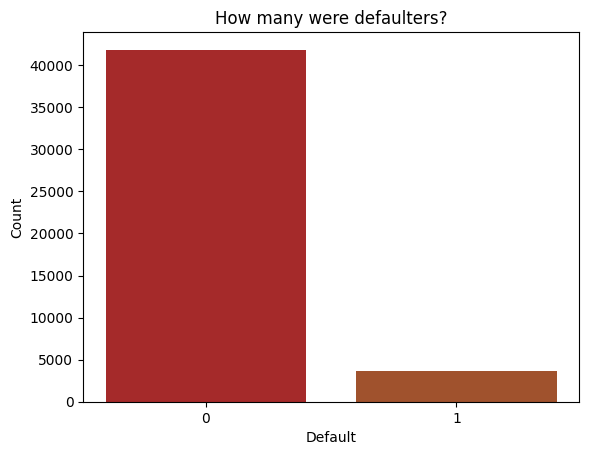

In [ ]:
shuffle(colors)
un, count = np.unique(data.credit_card_default, return_counts=True)
un = [str(int(i)) for i in un]
plt.bar(un, count, color = colors)
plt.xlabel("Default")
plt.ylabel("Count")
plt.title("How many were defaulters?")
plt.show()

<p><b>Inference : </b>Majority of them were <b>Non-Defaulters</b>.</p>

<h1>Modelling</h1>
<ul>
    <li>Encoding Categorical Values</li>
    <li>Oversampling using SMOTE</li>
    <li>Modelling using Random Forest</li>
</ul>

<h2>Drop columns that are not required</h2>

In [ ]:
data.drop(["name"],inplace=True,axis=1)

<h2>Label Encode Categorical Values</h2>

In [ ]:
enc = LabelEncoder()
data.gender = enc.fit_transform(data.gender)
data.owns_house = enc.fit_transform(data.owns_house)
data.owns_car = enc.fit_transform(data.owns_car)
data.occupation_type = enc.fit_transform(data.occupation_type)
data.migrant_worker = enc.fit_transform(data.migrant_worker)
data.in_profit = enc.fit_transform(data.in_profit)
data.credit_card_default = enc.fit_transform(data.credit_card_default)

In [ ]:
data

,customer_id,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,...,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,in_hand_balance,in_profit,total_income_received,employment_years
0,CST_115179,46,0,0,1,0.0,107934.04,612.0,17,1.0,...,18690.93,73,544.0,2,1,1,74863.76,1,6.605563e+07,1.676712
1,CST_121920,29,1,0,1,0.0,109862.62,2771.0,8,2.0,...,37745.19,52,857.0,0,0,0,94533.09,1,3.044293e+08,6.093151
2,CST_109330,37,1,0,1,0.0,230153.17,204.0,8,2.0,...,41598.36,43,650.0,0,0,0,181736.57,1,4.695125e+07,0.558904
3,CST_128288,39,0,0,1,0.0,122325.82,11941.0,3,2.0,...,32627.76,20,754.0,0,0,0,99751.46,1,1.460693e+09,6.093151
4,CST_151355,46,1,1,1,0.0,387286.00,1459.0,3,1.0,...,52950.64,75,927.0,0,0,0,349003.05,1,5.650503e+08,3.997260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,CST_130421,55,0,0,0,2.0,96207.57,117.0,17,4.0,...,29663.83,82,907.0,0,0,0,84978.03,1,1.125629e+07,0.320548
45524,CST_136670,31,0,0,1,0.0,383476.74,966.0,0,2.0,...,139947.16,32,679.0,0,0,0,340106.83,1,3.704385e+08,2.646575
45525,CST_145435,27,0,0,1,0.0,260052.18,1420.0,3,2.0,...,83961.83,46,727.0,0,0,0,237344.67,1,3.692741e+08,3.890411
45526,CST_130913,32,1,1,0,0.0,157363.04,2457.0,8,2.0,...,25538.72,92,805.0,0,0,0,137212.94,1,3.866410e+08,6.093151


<h2>Oversampling using SMOTE</h2>

In [ ]:
df_id=data['customer_id']
data.drop(["customer_id"],inplace=True,axis=1)

In [ ]:
features, labels = SMOTE().fit_resample(data.drop(["credit_card_default"],axis=1), data.credit_card_default)

In [ ]:
#data['customer_id']=df2
target=data["credit_card_default"]
train_data=data.drop(["credit_card_default"],axis=1)

In [ ]:
data

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,...,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,in_hand_balance,in_profit,total_income_received,employment_years
0,46,0,0,1,0.0,107934.04,612.0,17,1.0,1,...,18690.93,73,544.0,2,1,1,74863.76,1,6.605563e+07,1.676712
1,29,1,0,1,0.0,109862.62,2771.0,8,2.0,0,...,37745.19,52,857.0,0,0,0,94533.09,1,3.044293e+08,6.093151
2,37,1,0,1,0.0,230153.17,204.0,8,2.0,0,...,41598.36,43,650.0,0,0,0,181736.57,1,4.695125e+07,0.558904
3,39,0,0,1,0.0,122325.82,11941.0,3,2.0,0,...,32627.76,20,754.0,0,0,0,99751.46,1,1.460693e+09,6.093151
4,46,1,1,1,0.0,387286.00,1459.0,3,1.0,0,...,52950.64,75,927.0,0,0,0,349003.05,1,5.650503e+08,3.997260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,55,0,0,0,2.0,96207.57,117.0,17,4.0,0,...,29663.83,82,907.0,0,0,0,84978.03,1,1.125629e+07,0.320548
45524,31,0,0,1,0.0,383476.74,966.0,0,2.0,1,...,139947.16,32,679.0,0,0,0,340106.83,1,3.704385e+08,2.646575
45525,27,0,0,1,0.0,260052.18,1420.0,3,2.0,0,...,83961.83,46,727.0,0,0,0,237344.67,1,3.692741e+08,3.890411
45526,32,1,1,0,0.0,157363.04,2457.0,8,2.0,0,...,25538.72,92,805.0,0,0,0,137212.94,1,3.866410e+08,6.093151


<h2>Modelling</h2>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                    labels,
                                                    test_size = 0.2,
                                                    shuffle=True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(random_state=0,n_estimators=1000)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

<h2>Metrics</h2>

In [ ]:
print("Train Accuracy  : {:.2f}%".format(accuracy_score(rf.predict(X_train),Y_train)*100))
print("Test Accuracy   : {:.2f}%".format(accuracy_score(rf.predict(X_test),Y_test)*100))
print("Precision       : {:.2f}%".format(precision_score(rf.predict(X_test),Y_test)*100))
print("Recall          : {:.2f}%".format(recall_score(rf.predict(X_test),Y_test)*100))

Train Accuracy  : 100.00%
Test Accuracy   : 98.64%
Precision       : 99.45%
Recall          : 97.86%


<h2>Confusion Matrix</h2>

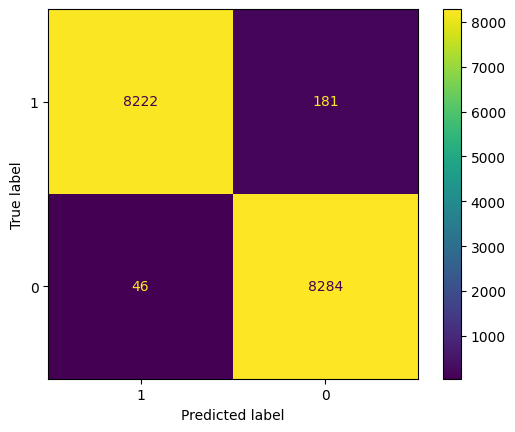

In [ ]:
cm = confusion_matrix(Y_test,rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=["1","0"])
disp.plot()

In [ ]:
X_test

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,in_hand_balance,in_profit,total_income_received,employment_years
56667,34,0,0,0,0.000000,145499.883317,365250.648536,17,1.849837,0,34385.242897,25017.485933,89,608.137153,1,1,111114.640420,1,5.314393e+10,6.093151
29873,52,0,0,1,0.000000,120532.810000,3166.000000,8,2.000000,0,25127.150000,23868.970000,67,748.000000,0,0,95405.660000,1,3.816069e+08,6.093151
53651,40,0,0,0,0.629346,142144.981090,450.957580,11,2.629346,0,26269.152684,28606.869302,93,576.262863,1,0,115875.828406,1,6.407536e+07,1.235500
26751,39,0,0,0,0.000000,156175.270000,1602.000000,11,2.000000,0,19329.580000,43816.010000,4,875.000000,0,0,136845.690000,1,2.501928e+08,4.389041
5727,28,1,0,1,0.000000,151601.440000,5822.000000,8,1.000000,1,12984.820000,51017.480000,50,882.000000,0,0,138616.620000,1,8.826236e+08,6.093151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28467,46,0,0,1,0.000000,141647.110000,885.000000,1,2.000000,1,52411.780000,34594.550000,48,659.000000,0,0,89235.330000,1,1.253577e+08,2.424658
45682,51,1,0,0,0.000000,204041.149737,1086.794577,10,1.281170,0,22698.253491,25695.230897,86,544.928647,0,0,181342.896245,1,2.103987e+08,2.977519
49530,52,0,0,1,0.000000,161012.386275,4509.994670,3,1.708165,0,27088.211904,33532.202050,82,576.700069,1,0,133924.174370,1,6.897079e+08,6.093151
72047,34,1,0,0,0.000000,177328.285770,1981.018136,7,1.838041,0,40709.651142,53302.518990,76,560.244919,0,0,136618.634628,1,3.375427e+08,5.427447


In [ ]:
test = pd.read_csv('/content/test.csv')
test_id = test['customer_id']
test_name = test['name']
test.drop(['customer_id','name'],axis=1,inplace=True)
test

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,53,F,N,N,0.0,266824.38,3051.0,Sales staff,1.0,0.0,17791.56,64483.93,74,823.0,0,0
11379,33,F,NaN,N,0.0,124310.85,365248.0,Unknown,1.0,0.0,26576.79,29851.73,60,712.0,0,0
11380,27,M,Y,Y,1.0,364652.81,3431.0,Laborers,3.0,0.0,28658.55,69336.96,67,674.0,0,0
11381,36,F,N,Y,0.0,128769.02,16320.0,Medicine staff,1.0,0.0,11527.38,26908.03,17,684.0,0,0


In [ ]:
test.isna().sum()

,0
age,0
gender,0
owns_car,132
owns_house,0
no_of_children,190
net_yearly_income,0
no_of_days_employed,105
occupation_type,0
total_family_members,31
migrant_worker,26


In [ ]:
test.no_of_children.fillna(np.median(test.no_of_children.dropna()), inplace=True)
test.no_of_days_employed.fillna(np.median(test.no_of_days_employed.dropna()), inplace=True)
test.total_family_members.fillna(np.median(test.total_family_members.dropna()), inplace=True)
test.yearly_debt_payments.fillna(np.median(test.yearly_debt_payments.dropna()), inplace=True)
test.credit_score.fillna(np.median(test.credit_score.dropna()), inplace=True)
test.migrant_worker.fillna(test.migrant_worker.mode().values[0],inplace=True)
test.owns_car.fillna(test.owns_car.mode().values[0],inplace=True)

In [ ]:
def get_profit_category(value):
    if value < 0 :
        return "Loss"
    elif value == 0 :
        return "Zero"
    else:
        return "Profit"

test["in_hand_balance"] = (test.net_yearly_income - test.yearly_debt_payments)
test["in_profit"] = [get_profit_category(i) for i in test["in_hand_balance"].values]
test["total_income_received"] = test.net_yearly_income * test.no_of_days_employed
test["employment_years"] = (test.no_of_days_employed / 365.0)

In [ ]:
enc = LabelEncoder()
test.gender = enc.fit_transform(test.gender)
test.owns_house = enc.fit_transform(test.owns_house)
test.owns_car = enc.fit_transform(test.owns_car)
test.occupation_type = enc.fit_transform(test.occupation_type)
test.migrant_worker = enc.fit_transform(test.migrant_worker)
test.in_profit = enc.fit_transform(test.in_profit)

In [ ]:
test

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,in_hand_balance,in_profit,total_income_received,employment_years
0,52,0,1,0,0.0,232640.53,998.0,17,2.0,0,14406.73,26524.40,4,779.0,0,0,218233.80,1,2.321752e+08,2.734247
1,48,0,0,0,1.0,284396.79,1338.0,17,3.0,0,57479.99,68998.72,70,806.0,0,0,226916.80,1,3.805229e+08,3.665753
2,50,0,0,0,1.0,149419.28,1210.0,17,3.0,0,21611.01,25187.80,71,528.0,2,0,127808.27,1,1.807973e+08,3.315068
3,30,0,0,0,1.0,160437.54,503.0,8,2.0,1,28990.76,29179.39,9,815.0,0,0,131446.78,1,8.070008e+07,1.378082
4,52,1,0,1,0.0,233480.37,157.0,8,2.0,1,54213.72,82331.82,82,613.0,1,1,179266.65,1,3.665642e+07,0.430137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,53,0,0,0,0.0,266824.38,3051.0,14,1.0,0,17791.56,64483.93,74,823.0,0,0,249032.82,1,8.140812e+08,8.358904
11379,33,0,0,0,0.0,124310.85,365248.0,17,1.0,0,26576.79,29851.73,60,712.0,0,0,97734.06,1,4.540429e+10,1000.679452
11380,27,1,1,1,1.0,364652.81,3431.0,8,3.0,0,28658.55,69336.96,67,674.0,0,0,335994.26,1,1.251124e+09,9.400000
11381,36,0,0,1,0.0,128769.02,16320.0,11,1.0,0,11527.38,26908.03,17,684.0,0,0,117241.64,1,2.101510e+09,44.712329


In [ ]:
test.isna().sum()

,0
age,0
gender,0
owns_car,0
owns_house,0
no_of_children,0
net_yearly_income,0
no_of_days_employed,0
occupation_type,0
total_family_members,0
migrant_worker,0


In [ ]:
test_predict = rf.predict(test)
type(test_predict)
type(test_id)
#test_predict['customer_id']=test_id
#test_final = test_id.merge(test_predict)
#test_predict

pandas.core.series.Series

In [ ]:
import pandas as pd
import numpy as np

final=pd.DataFrame(np.column_stack([test_id, test_predict]),columns = ['customer_id', 'credit_card_default'])
final.to_csv('submission.csv')

In [ ]:
data

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,...,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,in_hand_balance,in_profit,total_income_received,employment_years
0,46,0,0,1,0.0,107934.04,612.0,17,1.0,1,...,18690.93,73,544.0,2,1,1,74863.76,1,6.605563e+07,1.676712
1,29,1,0,1,0.0,109862.62,2771.0,8,2.0,0,...,37745.19,52,857.0,0,0,0,94533.09,1,3.044293e+08,6.093151
2,37,1,0,1,0.0,230153.17,204.0,8,2.0,0,...,41598.36,43,650.0,0,0,0,181736.57,1,4.695125e+07,0.558904
3,39,0,0,1,0.0,122325.82,11941.0,3,2.0,0,...,32627.76,20,754.0,0,0,0,99751.46,1,1.460693e+09,6.093151
4,46,1,1,1,0.0,387286.00,1459.0,3,1.0,0,...,52950.64,75,927.0,0,0,0,349003.05,1,5.650503e+08,3.997260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45523,55,0,0,0,2.0,96207.57,117.0,17,4.0,0,...,29663.83,82,907.0,0,0,0,84978.03,1,1.125629e+07,0.320548
45524,31,0,0,1,0.0,383476.74,966.0,0,2.0,1,...,139947.16,32,679.0,0,0,0,340106.83,1,3.704385e+08,2.646575
45525,27,0,0,1,0.0,260052.18,1420.0,3,2.0,0,...,83961.83,46,727.0,0,0,0,237344.67,1,3.692741e+08,3.890411
45526,32,1,1,0,0.0,157363.04,2457.0,8,2.0,0,...,25538.72,92,805.0,0,0,0,137212.94,1,3.866410e+08,6.093151


from matplotlib import pyplot as plt
data['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['gender'].plot(kind='hist', bins=20, title='gender')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['owns_car'].plot(kind='hist', bins=20, title='owns_car')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['owns_house'].plot(kind='hist', bins=20, title='owns_house')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='age', y='gender', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='gender', y='owns_car', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='owns_car', y='owns_house', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='owns_house', y='no_of_children', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['gender'].plot(kind='line', figsize=(8, 4), title='gender')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['owns_car'].plot(kind='line', figsize=(8, 4), title='owns_car')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['owns_house'].plot(kind='line', figsize=(8, 4), title='owns_house')
plt.gca().spines[['top', 'right']].set_visible(False)